# Accelerations and decelerations from Maeda et al. 2012

## Summary

This notebook implements the method for acceleration and deceleration detection from Maeda et al. 2012, based on the MATLAB implemention in the FHRMA package.

The paper: [Maeda et al. 2012](https://benthamopen.com/contents/pdf/TOMDJ/TOMDJ-4-28.pdf) - Central Computerized Automatic Fetal Heart Rate Diagnosis with a Rapid and Direct Alarm System

**Observations:**
* The FHRMA/MATLAB implementation sometimes differed from my interpretation of the paper description. I noticed this to be the case reference lines in accelerations/decelerations, which are described in the paper but not implemented in the code

## Paper description of method

* **Reference line** - "Data-to-data difference in FHR were averaged (F bpm) and added to the baseline data to define the upper reference line (FHR baseline + F/2), and subtracted from the baseline data to define the lower reference line (FHR baseline –F/2)."
* **Deceleration** - "A transient FHR decrease of more than 15 bpm below the lower reference line lasting longer than 15 seconds was defined as a deceleration. An FHR decrease appearing during transient tachycardia with a nadir of 110 bpm or more was not considered a deceleration but instead a transient recovery to the normal baseline."
* **Late Deceleration** - "The DIP SHAPE value was applied to the classification of deceleration, and was calculated by dividing the dip area ((sum of the FHR data in the deceleration) x 2) by ((deceleration amplitude x duration (seconds)) (Fig. 2). A decrease in FHR was defined as late deceleration (LD) if the following four conditions were met within 15 minutes: (1) the lag time between the contraction peak and FHR nadir was longer than 20 seconds in 60 % or more decelerations: (2) the number of deceleration was more than the contraction number – 1: (3) the DIP SHAPE value was less than 0.5: and (4) the dip variability (sum of FHR n – FHR n-1 in the deceleration) was less than 60 bpm). A decrease in FHR was defined as early deceleration (ED) if the DIP SHAPE value was less than 0.5, dip irregularity was less than 60 bpm and the lag time was almost zero."
* **Variable Deceleration** - "A decrease in FHR was defined as a variable deceleration (VD) if the DIP SHAPE was greater than 0.6 and dip variability was greater than 60 bpm"
* **Severe variable Deceleration** - A variable deceleration with a nadir heart rate less than 100 bpm and duration longer than 60 seconds was defined as severe variable deceleration (SVD)
* **Prolonged Deceleration** - Deceleration lasting longer than 2 minutes
* **Acceleration** - A transient rise in FHR of 15 bpm or more above the upper reference line lasting 15 seconds or more , after 30 weeks of pregnancy, was defined as FHR acceleration 

## MATLAB implementation

Boudet et al. implement this method [in the FHRMA toolbox using MATLAB](https://github.com/utsb-fmm/FHRMA/blob/master/aammaeda.m), and this is copied below. First, I have described my understanding of what this function is doing.

for accelerations, detect accident...
* signal = fhr - baseline
* threshold = 15
* peaks are where the signal is greater than the threshold
* find the start, end and maximum points of those accidents
* if segment is longer than 15 seconds (15*4) then it is classed as an accident

minus int...
* a = outcome of detect accident
* f = rerun detect accident but with threshold of 5
* removes elements from f that are also in a

it does likewise for decelerations, but instead, signal = baseline - fhr.

They state that Maeda's method for acceleration and deceleration detection is the same as the standard simple method used in their toolbox.

**Note:** This appears to exclude the paper's concept of reference lines, which is ambiguous, but i think might be about finding the average difference between each 2second bpm HR reading and adding that to the 15bpm difference required from baseline

```
function [acc,dec,falseacc,falsedec]=simpleaddetection(fhr,baseline)

acc=detectaccident(fhr-baseline,15);
dec=detectaccident(baseline-fhr,15);
falseacc=minusint(acc,detectaccident(fhr-baseline,5));
falsedec=minusint(dec,detectaccident(baseline-fhr,5));
end

function accidentsample=detectaccident(sig,thre)

peaks=find(sig>thre);
accidentsample=zeros(3,0);
while ~isempty(peaks)
    dacc=find(sig(1:peaks)<0,1,'last');
    if isempty(dacc)
        dacc=1;
    end
    facc=find(sig(dacc+1:end)<0,1,'first')+dacc;
    if isempty(facc)
        facc=length(sig);
    end
    [~,macc]=max(sig(dacc:facc));
    macc=macc+dacc-1;
    if facc-dacc>15*4
        accidentsample=[accidentsample [dacc;facc;macc]/4];
    end   
    peaks=peaks(peaks>facc);
end
end

function f=minusint(a,f)

for i=1:size(a,2)
    n=find(f(1,:)>=a(1,i) &f(2,:)<=a(2,i));
    if ~isempty(n)
        f=f(:,[1:n-1 n+1:end]);
    end
end
    
end
```

## Python implementation

In order to ensure a fair comparison against FHRMA results, this implemention uses:
* The FHR baseline from FHRMA
* The cleaned FHR signal as from running FHRMA in MATLAB

This is as opposed to using the baseline and cleaned FHR signal I generated in Python, which may still be in the process of correcting to ensure a match to FHRMA/MATLAB.

### Set up

Import required packages

In [1]:
# Import packages
import copy
from dataclasses import dataclass
import glob
from itertools import compress, groupby
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import pandas as pd
from scipy import io
from statistics import multimode

Define file paths

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    clean_fhr = './data/clean_fhr_matlab/'
    md_std = './data/MD_std.mat'


paths = Paths()

Define function for importing all csv files in a directory

In [3]:
def import_csv(directory, output_dict):
    '''
    Import csv files from provided directory and save to output_dict
    Inputs:
    directory - string, location of csv files
    output_dict - dictionary, to save files to
    '''
    # Get list of .csv files in directory
    files = glob.glob(os.path.join(directory, '*.csv'))

    # Loop through files in the directory
    for file in files:
        # Get raw name of record (without path or file type)
        name = file.replace(directory, '').replace('.csv', '')
        # Import and save to dictionary
        output_dict[name] = pd.read_csv(file, header=None)[0].values

    return output_dict

Load the cleaned FHR data

In [4]:
raw_fhr = import_csv(
    directory=paths.clean_fhr,
    output_dict=dict())

Load the baseline, accelerations and decelerations for Maeda et al. 2012 from FHRMA

In [5]:
# Load FHRMA version of results
md_std = io.loadmat(paths.md_std)

# Get array listing filenames (and hence order of the data)
fhrma_files = np.concatenate(np.concatenate(md_std['data']['filename']))

# Get array with the baseline signal as per Maeda when implemented in FHRMA
fhrma_md = np.concatenate(md_std['data']['baseline'])
# Convert array into dictionary so each record is accompanied by relevant name
fhrma_maeda_base = {
    fhrma_files[i].replace('.fhr', ''): 
    fhrma_md[i][0] for i in range(len(fhrma_files))}

# Same for accelerations
fhrma_md_acc = np.concatenate(md_std['data']['accelerations'])
fhrma_maeda_acc = {
    fhrma_files[i].replace('.fhr', ''): 
    fhrma_md_acc[i] for i in range(len(fhrma_files))}

# Same for decelerations
fhrma_md_dec = np.concatenate(md_std['data']['decelerations'])
fhrma_maeda_dec = {
    fhrma_files[i].replace('.fhr', ''): 
    fhrma_md_dec[i] for i in range(len(fhrma_files))}

### Define function for detecting accelerations or decelerations

In [6]:
def detect_accident(sig, thre):
    '''
    Detect accelerations or decelerations by comparing difference betweeen FHR
    and FHR baseline against a specified threshold.

    Parameters:
    -----------
    sig: array
        Difference between signal and baseline - for accelerations this is
        fhr-baseline, and for decelerations this is baseline-fhr
    thre: int
        Threshold for difference

    Outputs:
    --------
    result: dataframe
        Dataframe with the time in seconds where a peak start and began, and 
        index for the maximum of the peak (and for decelerations, this is
        referring to a trough and the max of that trough)
    '''
    # Create empty list to store result
    res = []

    # Find points where value is greater than the threshold
    peaks = np.argwhere(sig > thre).ravel()

    # While we have points in peaks
    while len(peaks) > 0:

        # Extract all of sig before the first peak
        before = sig[:peaks[0]]

        # Find index of last point before peak that is < 0
        # E.g. For accelerations, last point where FHR is not past baseline
        dacc = np.argwhere(before < 0).ravel()
        if len(dacc) > 0:
            dacc = dacc[-1]
        else:
            dacc = 0

        # Extract all of signal after that point
        after = sig[dacc+1:]

        # Find index of first point after then that is < 0
        # Adding dacc+1 to convert it to actual location in signal (not just after peak)
        facc = np.argwhere(after < 0).ravel()
        if len(facc > 0):
            facc = facc[0] + dacc + 1
        else:
            facc = len(sig)-1

        # Filter to the values between dacc and facc (so array just has values > 0)
        interval = sig[dacc+1:facc]

        # Find the index of the maximum value in that interval
        # Adding dacc+1 to convert it to actual location in signal
        macc = np.argmax(interval) + dacc + 1

        # Check if length of interval is more than 15 seconds - if so, save result,
        # dividing each value by 4 so it is in seconds rather than quarter seconds -
        # and by 60 so it is in minutes rather than seconds - and plus 1 so it
        # matches the MATLAB results (as that is 1-indexed)
        if len(interval) >= 15*4:
            res.append([(x+1)/4/60 for x in [dacc, facc, macc]])

        # Filter to peaks that fall after interval explored
        peaks = peaks[peaks > facc]

    # Convert result to dataframe
    result = pd.DataFrame(res, columns=['start', 'end', 'max'])

    return (result)

### Run on all records

In [7]:
# Initialise empty to lists to store results
acc = []
dec = []

# Loop through each of the FHR signals
for record, fhr in raw_fhr.items():

    # Get baseline for that record
    baseline = fhrma_maeda_base[record]

    # Get results from FHRMA for that record
    fhrma_acc = fhrma_maeda_acc[record]
    fhrma_dec = fhrma_maeda_dec[record]

    # Get accelerations and decelerations using python function above
    python_acc = detect_accident(fhr-baseline, 15)[['start', 'end']].to_numpy()
    python_dec = detect_accident(baseline-fhr, 15)[['start', 'end']].to_numpy()

    # Check if all match
    acc_match = np.array_equal(fhrma_acc, python_acc)
    dec_match = np.array_equal(fhrma_dec, python_dec)

    # Store in results
    acc.append([record, fhrma_acc, python_acc, acc_match])
    dec.append([record, fhrma_dec, python_dec, dec_match])

# Convert to dataframe
acc_result = pd.DataFrame(acc, columns=['record', 'fhrma', 'python', 'match'])
dec_result = pd.DataFrame(acc, columns=['record', 'fhrma', 'python', 'match'])

### Accelerations comparison to FHRMA

#### Compare all

In [8]:
acc_result.head()

,record,fhrma,python,match
0,train28,"[[9.9125, 11.091666666666667], [13.325, 14.779...","[[9.9125, 11.091666666666667], [13.325, 14.779...",True
1,test80,"[[6.470833333333333, 9.054166666666667], [14.6...","[[6.470833333333333, 9.054166666666667], [14.6...",True
2,test68,"[[0.004166666666666667, 5.033333333333333], [8...","[[0.004166666666666667, 5.033333333333333], [8...",True
3,train04,"[[4.125, 5.491666666666666], [7.3625, 10.50416...","[[4.125, 5.491666666666666], [7.3625, 10.50416...",True
4,train31,"[[19.225, 19.591666666666665], [20.325, 20.904...","[[19.225, 19.591666666666665], [20.325, 20.904...",True


In [9]:
acc_result['match'].value_counts()

match
True    156
Name: count, dtype: int64

In [10]:
def compare_means(df, x, y, title):
    '''
    Create scatterpol comparing two columns from df.
    Inputs:
    df - dataframe, to plot from
    x - string, name of column for x axis
    y - string, name of column for y axis
    '''
    fig, ax = plt.subplots()
    ax.scatter(x=df[x], y=df[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.grid()
    ax.set_box_aspect(1)
    plt.show()

acc_count_diff
0    156
Name: count, dtype: int64

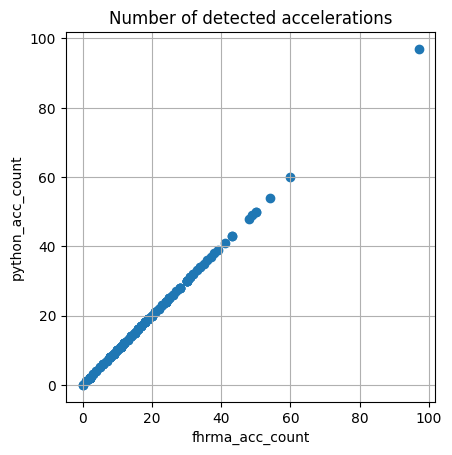

In [11]:
# Get number of accelerations for each record
acc_result['fhrma_acc_count'] = [len(x) for x in acc_result['fhrma']]
acc_result['python_acc_count'] = [len(x) for x in acc_result['python']]

# Show difference
acc_result['acc_count_diff'] = acc_result['python_acc_count'] - acc_result['fhrma_acc_count']
display(acc_result['acc_count_diff'].value_counts())

# Plot comparison
compare_means(acc_result, 'fhrma_acc_count', 'python_acc_count',
              'Number of detected accelerations')

In [12]:
def find_length(arr):
    '''
    Find the length of each detected acceleration and save to array

    Parameters:
    -----------
    arr : array
        Array with pairs of start and stop times for acceleration or deceleration

    Returns:
    --------
    lengths : array
        Array with length of each acceleration or deceleration
    '''
    lengths = []
    for row in np.arange(0, len(arr)):
        lengths.append(arr[row][1] - arr[row][0])
    return(lengths)

acc_total_diff
0.0    156
Name: count, dtype: int64

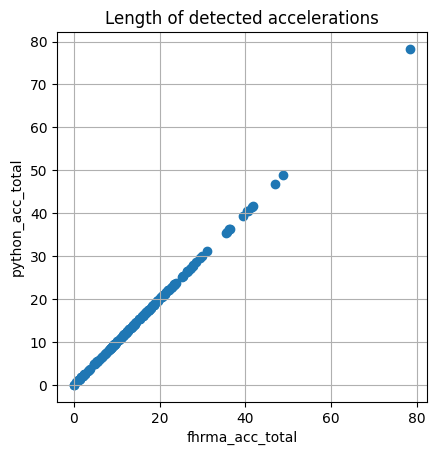

In [13]:
# Find lengths of each of the accelerations and decelerations
acc_result['fhrma_acc_length'] = [find_length(x) for x in acc_result['fhrma']]
acc_result['python_acc_length'] = [find_length(x) for x in acc_result['python']]

# Get total length for each
acc_result['fhrma_acc_total'] = [sum(x) for x in acc_result['fhrma_acc_length']]
acc_result['python_acc_total'] = [sum(x) for x in acc_result['python_acc_length']]

# Get difference in total length
acc_result['acc_total_diff'] = acc_result['python_acc_total'] - acc_result['fhrma_acc_total']
display(acc_result['acc_total_diff'].value_counts())

# Plot comparison
compare_means(acc_result, 'fhrma_acc_total', 'python_acc_total',
              'Length of detected accelerations')

### Decelerations

#### Compare all

In [14]:
dec_result.head()

,record,fhrma,python,match
0,train28,"[[9.9125, 11.091666666666667], [13.325, 14.779...","[[9.9125, 11.091666666666667], [13.325, 14.779...",True
1,test80,"[[6.470833333333333, 9.054166666666667], [14.6...","[[6.470833333333333, 9.054166666666667], [14.6...",True
2,test68,"[[0.004166666666666667, 5.033333333333333], [8...","[[0.004166666666666667, 5.033333333333333], [8...",True
3,train04,"[[4.125, 5.491666666666666], [7.3625, 10.50416...","[[4.125, 5.491666666666666], [7.3625, 10.50416...",True
4,train31,"[[19.225, 19.591666666666665], [20.325, 20.904...","[[19.225, 19.591666666666665], [20.325, 20.904...",True


In [15]:
dec_result['match'].value_counts()

match
True    156
Name: count, dtype: int64

In [16]:
dec_result[dec_result['match'] == False]

,record,fhrma,python,match


dec_count_diff
0    156
Name: count, dtype: int64

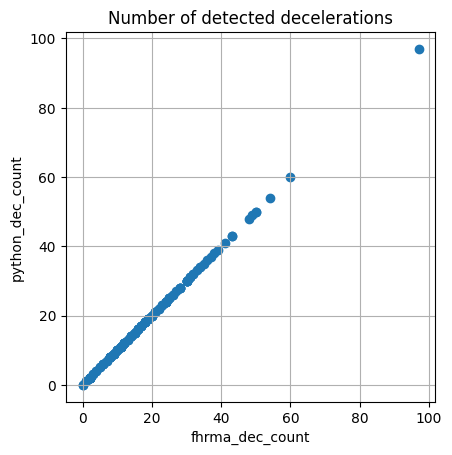

In [17]:
# Get number of accelerations for each record
dec_result['fhrma_dec_count'] = [len(x) for x in dec_result['fhrma']]
dec_result['python_dec_count'] = [len(x) for x in dec_result['python']]

# Show difference
dec_result['dec_count_diff'] = dec_result['python_dec_count'] - dec_result['fhrma_dec_count']
display(dec_result['dec_count_diff'].value_counts())

# Plot comparison
compare_means(dec_result, 'fhrma_dec_count', 'python_dec_count',
              'Number of detected decelerations')

dec_total_diff
0.0    156
Name: count, dtype: int64

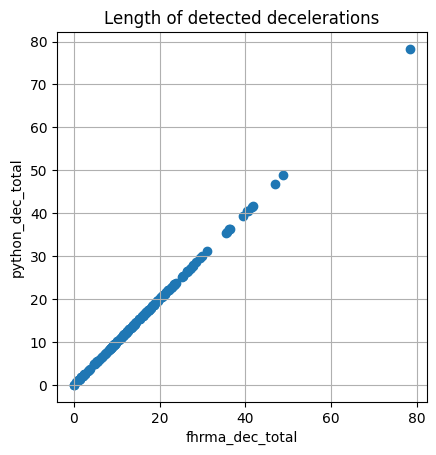

In [18]:
# Find lengths of each of the accelerations and decelerations
dec_result['fhrma_dec_length'] = [find_length(x) for x in dec_result['fhrma']]
dec_result['python_dec_length'] = [find_length(x) for x in dec_result['python']]

# Get total length for each
dec_result['fhrma_dec_total'] = [sum(x) for x in dec_result['fhrma_dec_length']]
dec_result['python_dec_total'] = [sum(x) for x in dec_result['python_dec_length']]

# Get difference in total length
dec_result['dec_total_diff'] = dec_result['python_dec_total'] - dec_result['fhrma_dec_total']
display(dec_result['dec_total_diff'].value_counts())

# Plot comparison
compare_means(dec_result, 'fhrma_dec_total', 'python_dec_total',
              'Length of detected decelerations')